# Chapter Goals
- Dealing with missing values in learning.
- Modeling, while avoiding over-fitting, by pruning (tree and rules)
- Industrial algorithms

# General Lab Guidlines
- Visualization.
- Modifiable code snippets.

# Further
- How is _cost complexity pruning_ a post-pruning method, while a tree is built from scratch? Any library implementing the subtree raise method?

---

In [ ]:
# Loading a dataset
# dataset names: "airline", "breast-cancer", "contact-lenses", "cpu", "cpu.with.vendor", "credit-g", "diabetes", "glass", "hypothyroid", "ionosphere", "iris.2D", "iris", "labor", "segment-challenge", "segment-test", "soybean", "supermarket", "unbalanced", "vote", "weather.nominal", "weather.numeric"
# df = pd.read_csv("data/weather.numeric.csv")
# instances = loader.load_file("data/weather.numeric.arff")

# Modules & Datasets Setup

In [ ]:
# @title
!apt-get install default-jdk
!apt install libgraphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
default-jdk is already the newest version (2:1.11-72build2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
# @title
!pip install pygraphviz
!pip install python-javabridge
!pip install python-weka-wrapper3
!pip install sklearn-weka-plugin

In [ ]:
# @title
#Restart runtime after installing the dependencies

In [ ]:
# @title
import os
import glob
import numpy as np
import pandas as pd
import weka.core.jvm as jvm
from weka.core import converters
import matplotlib.pyplot as plt

In [ ]:
# @title
data_dir = 'data'

In [ ]:
# @title
#!rm -r weka
#!rm -r data

In [ ]:
# @title
#jvm.stop()
jvm.start(packages=True)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/usr/local/lib/python3.10/dist-packages/javabridge/jars/rhino-1.7R4.jar', '/usr/local/lib/python3.10/dist-packages/javabridge/jars/runnablequeue.jar', '/usr/local/lib/python3.10/dist-packages/javabridge/jars/cpython.jar', '/usr/local/lib/python3.10/dist-packages/weka/lib/arpack_combined.jar', '/usr/local/lib/python3.10/dist-packages/weka/lib/mtj.jar', '/usr/local/lib/python3.10/dist-packages/weka/lib/core.jar', '/usr/local/lib/python3.10/dist-packages/weka/lib/weka.jar', '/usr/local/lib/python3.10/dist-packages/weka/lib/python-weka-wrapper.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


In [ ]:
# @title
# Preparing Datasets
if not os.path.exists(data_dir):
    !mkdir $data_dir
    for file in ['airline.arff', 'breast-cancer.arff', 'contact-lenses.arff', 'cpu.arff', 'cpu.with.vendor.arff', 'credit-g.arff', 'diabetes.arff', 'glass.arff', 'hypothyroid.arff', 'ionosphere.arff', 'iris.2D.arff', 'iris.arff', 'labor.arff', 'segment-challenge.arff', 'segment-test.arff', 'soybean.arff', 'supermarket.arff', 'unbalanced.arff', 'vote.arff', 'weather.nominal.arff', 'weather.numeric.arff',]:
        url = 'https://git.cms.waikato.ac.nz/weka/weka/-/raw/main/trunk/wekadocs/data/' + file
        !wget -P $data_dir $url
    loader = converters.Loader(classname="weka.core.converters.ArffLoader")
    saver = converters.Saver(classname="weka.core.converters.CSVSaver")
    for file in glob.glob(os.path.join(data_dir, '*.arff')):
        dataset = loader.load_file(file)
        filename, file_extension = os.path.splitext(file)
        saver.save_file(dataset, filename + '.csv')
    !wget -P $data_dir https://raw.githubusercontent.com/Rytuo/ITMO-CT/master/Others/AdvancedML/data/OpenML/data/1438.arff
    !rm -r weka

In [ ]:
import weka.core.packages as packages
packages.install_package("simpleEducationalLearningSchemes")
packages.install_package("generalizedSequentialPatterns")
packages.install_package("classAssociationRules")

from weka.core.converters import Loader
loader = Loader(classname="weka.core.converters.ArffLoader")

# 6.1 Decision Trees

## Numeric Attributes

In [ ]:
# Discretization: Converting numeric to categorical.

import pandas as pd

sr = pd.Series([10, 20, 15, 5, 30, 25, 7, 12, 17, 22])

binEdges = [0, 10, 20, 30]
binLabels = ['Low', 'Medium', 'High']

categorized_sr = pd.cut(sr, bins=binEdges, labels=binLabels)

categorized_sr

0       Low
1    Medium
2    Medium
3       Low
4      High
5      High
6       Low
7    Medium
8    Medium
9      High
dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

**Task 1.1** Experiment with some dataset, and intuitively decide the number of labels.

**Task 1.2** Think of a general heuristic/strategy to optimize the number of labels.

## Missing Values

In [ ]:
# Use these probabilities to classify the row with missing value
# Assume the row has some label, then multiply the classification result by the corresponding probability
# Aggregate all classification answers

import pandas as pd
import random

# Create a sample DataFrame with missing values
df = pd.DataFrame({
    "F1": [random.choice([1, 2, 3, None]) for _ in range(30)],
    "F2": [random.choice(['A', 'B', 'C', None]) for _ in range(30)]
  }
)

# Function to compute sums and probabilities
def probabilitiesOfMissing(df, featureStr):
    # Drop rows with missing values in the feature
    df_no_missing = df.dropna(subset=[featureStr])

    # Calculate the sum of distinct values for the feature
    sums = df_no_missing[featureStr].value_counts()

    # Calculate the total sum
    total_sum = sums.sum()

    # Calculate the probability for each distinct value
    probabilities = sums / total_sum

    return sums, probabilities

# Compute sums and probabilities for Feature 2
sums2, probabilities2 = probabilitiesOfMissing(df, "F2")

print("Probabilities for F2:")
print(probabilities2)

Probabilities for F2:
A    0.476190
C    0.380952
B    0.142857
Name: F2, dtype: float64


**Task 1.3** Contrast this heuristic with dropping null values and with substituting missings by the average. Try to quantify your conclusions on some dataset.

## Pruning


In [ ]:
# cost complexity pruning
# reference: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the Iris dataset and split it into training and testing sets
iris = load_iris(); X = iris.data; y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prune the existing decision tree using the prune_path method
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Choose the alpha value for pruning
alpha_toPrune = 0.03  # You can adjust this value based on your data

# Prune the tree using the chosen alpha value
prunedTree = DecisionTreeClassifier(ccp_alpha=alpha_toPrune, random_state=42)
prunedTree.fit(X_train, y_train)

Original Decision Tree Accuracy: 1.00
Pruned Decision Tree Accuracy: 0.98


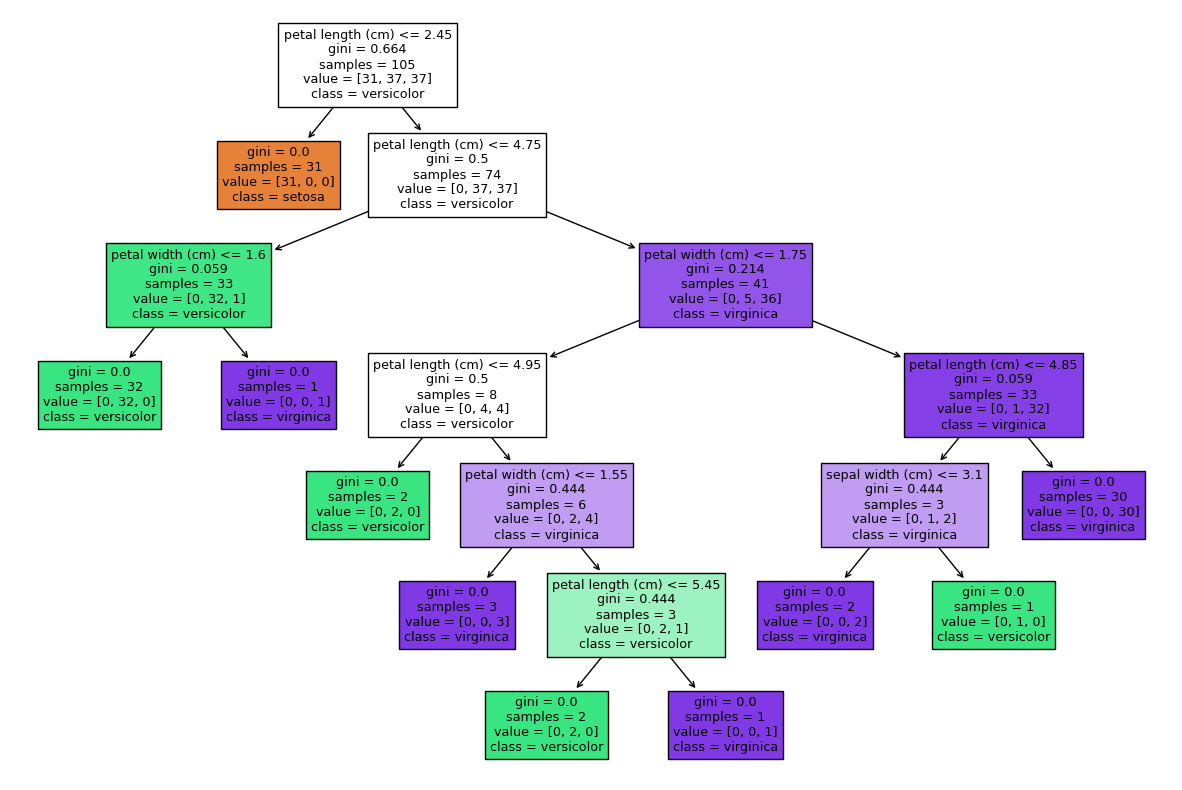

In [ ]:
# Original Tree

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

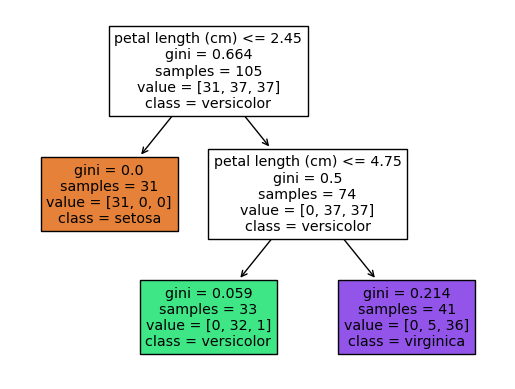

In [ ]:
# Pruned Tree

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot the decision tree
plot_tree(prunedTree, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

**Task 1.4** Construct couple of decision trees, and compare accuracies vs depth or nodes number. Through a visualization of these two measures, Guess the optimal tree.

# 6.2 Classification Rules

## Criteria for Choosing Tests

**Task 2.1** Refer back to Lab 04, Pick-up a rule-based algorithm, and assess error rate of a rule of your choice. Alternatively, You can use the code snippet of _Generating Good Rules_ section.

## Missing Values, Numeric Attributes

**Task 2.2** Refer back to Lab 04, Pick-up a rule-based algorithm, and some instance of your choice. Remove a feature from the instance, then re-classify it. You can use the code snippet of _Generating Good Rules_ to aid you in analysis.

## Generating Good Rules

In [ ]:
# Create a dummy DataFrame with random data

import pandas as pd
import random

df = pd.DataFrame({
    "F1": [random.choice(['A', 'B', 'C']) for _ in range(10)],
    "F2": [random.choice(['X', 'Y', 'Z']) for _ in range(10)],
    "class": [random.choice([0, 1]) for _ in range(10)]
})

Coverage of the rule for F1 = A: 5 rows
Accuracy of the rule: 40.00%


In [ ]:
# Coverate and Accuracy of a hand-crafted rule

import numpy as np

# Define a rule. If F1 = A, return 0
def myRule1(row):
  if row["F1"] == "A":
    return 0
  return np.NaN

# instances the rule is applicable on
# apply predicted class by our rule
instancesCovered = df.apply(myRule1, axis=1).dropna().to_frame(name="predictedClass")

# join data's class (ground truth)
instancesCovered = instancesCovered.join(df["class"])

# Coverage: Number of instances the rule is applicable on
ruleCoverage = len( instancesCovered )

# Number of correctly classified instances
count_CorrectlyClassified = (instancesCovered["predictedClass"] == instancesCovered["class"]).value_counts()[True]

# Accuracy: Number of correctly classified instances, out of covered instances
ruleAccuracy = count_CorrectlyClassified / ruleCoverage

print(f"Coverage: {ruleCoverage}")
print(f"Accuracy: {ruleAccuracy:.2%}")

Coverage: 5
Accuracy: 60.00%


**Task 2.3** Modify `myRule1` function to increase coverage and accuracy.

**Task 2.4** Partition the dataset into _training_ and _testing_. Apply _task 2.4_ on _training_ data without seeing _testing_. Compute accuracy and measures on _testing_. Note since data were randomly generated, You shouldn't expect rules well-generalizing

## Using Global Optimization

In [ ]:
# train model
# from weka.classifiers import Classifier
# cls = Classifier(classname="weka.classifiers.rules.JRip")
# cls.build_classifier(instances)

**Task 2.5** Refer back to Lab 04, Use the above code snipper on the same template of the lab.

## Rules with Exceptions

**Task 2.6** Refer back to Lab 04, on XOR classifier. Modify the code so that it has a default output with exceptions. Outputs must be equivalent to the original code.

# 6.3 Association Rules

Sources
- [FP-Growth by Weka](https://weka.sourceforge.io/doc.dev/weka/associations/FPGrowth.html)
- [Generalized Sequential Petterns by Weka](https://weka.sourceforge.io/doc.packages/generalizedSequentialPatterns/weka/associations/GeneralizedSequentialPatterns.html)
- [CBA by weka](https://weka.sourceforge.io/doc.packages/classAssociationRules/weka/classifiers/rules/car/JCBA.html)

## Generalized Sequential Petterns

In [ ]:
# weather nominal dataset
instances = loader.load_file("data/weather.nominal.arff")
instances

@relation weather.symbolic

@attribute outlook {sunny,overcast,rainy}
@attribute temperature {hot,mild,cool}
@attribute humidity {high,normal}
@attribute windy {TRUE,FALSE}
@attribute play {yes,no}

@data
sunny,hot,high,FALSE,no
sunny,hot,high,TRUE,no
overcast,hot,high,FALSE,yes
rainy,mild,high,FALSE,yes
rainy,cool,normal,FALSE,yes
rainy,cool,normal,TRUE,no
overcast,cool,normal,TRUE,yes
sunny,mild,high,FALSE,no
sunny,cool,normal,FALSE,yes
rainy,mild,normal,FALSE,yes
sunny,mild,normal,TRUE,yes
overcast,mild,high,TRUE,yes
overcast,hot,normal,FALSE,yes
rainy,mild,high,TRUE,no

In [ ]:
# train model
from weka.associations import Associator
associator = Associator(classname="weka.associations.GeneralizedSequentialPatterns")
associator.build_associations(instances)

In [ ]:
# model inspection
associator.description

<bound method OptionHandler.description of 
Apriori

Minimum support: 0.15 (2 instances)
Minimum metric <confidence>: 0.9
Number of cycles performed: 17

Generated sets of large itemsets:

Size of set of large itemsets L(1): 12

Size of set of large itemsets L(2): 47

Size of set of large itemsets L(3): 39

Size of set of large itemsets L(4): 6

Best rules found:

 1. outlook=overcast 4 ==> play=yes 4    <conf:(1)> lift:(1.56) lev:(0.1) [1] conv:(1.43)
 2. temperature=cool 4 ==> humidity=normal 4    <conf:(1)> lift:(2) lev:(0.14) [2] conv:(2)
 3. humidity=normal windy=FALSE 4 ==> play=yes 4    <conf:(1)> lift:(1.56) lev:(0.1) [1] conv:(1.43)
 4. outlook=sunny play=no 3 ==> humidity=high 3    <conf:(1)> lift:(2) lev:(0.11) [1] conv:(1.5)
 5. outlook=sunny humidity=high 3 ==> play=no 3    <conf:(1)> lift:(2.8) lev:(0.14) [1] conv:(1.93)
 6. outlook=rainy play=yes 3 ==> windy=FALSE 3    <conf:(1)> lift:(1.75) lev:(0.09) [1] conv:(1.29)
 7. outlook=rainy windy=FALSE 3 ==> play=yes 3    <co